Authors: Dror & Mariia

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from collections import Counter
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import time
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
# plt.rcParams["patch.force_edgecolor"] = True
# plt.style.use('fivethirtyeight')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [3]:
df = pd.read_csv('customer_segmentation.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str}) # from https://www.kaggle.com/carrie1/ecommerce-data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## 1 First, let's see what data do we have

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.duplicated().sum()

5268

## 2 EDA

### 2.1. 25% of entries are null-valued customers. 

So, let's select this subgroup, save it separately and later check it. Should it be removed from our main data? 

Since we are clustering orders, these orders with undefined customers will be assigned to the same customer if we do some fillna - this is bad. Probably, we have to work with that data separately

In [7]:
null_customers = df[df.CustomerID.isna()]
null_customers.to_csv('null_customers.csv')  # later we will return to this
null_customers.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom


Now, we will deal with data without NaNs:

In [8]:
# a few options
df1 = df.dropna(axis = 0, subset = ['CustomerID'])
df2 = df[~df.CustomerID.isna()] 
np.all(df1 == df2)

True

### 2.2. Duplicates

In [9]:
df1.duplicated().sum()

5225

In [10]:
df = df1.drop_duplicates()

In [11]:
df.info()  # maybe reset index?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      401604 non-null object
StockCode      401604 non-null object
Description    401604 non-null object
Quantity       401604 non-null int64
InvoiceDate    401604 non-null datetime64[ns]
UnitPrice      401604 non-null float64
CustomerID     401604 non-null object
Country        401604 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.6+ MB


In [12]:
dfr = df.reset_index()

### 2.3. Transform 'InvoiceDate' into some number of separate features

In [13]:
df['year'] = pd.DatetimeIndex(df['InvoiceDate']).year
df['month'] = pd.DatetimeIndex(df['InvoiceDate']).month
df['dayofweek'] = pd.DatetimeIndex(df['InvoiceDate']).dayofweek
df['weekofyear'] = pd.DatetimeIndex(df['InvoiceDate']).weekofyear
df['hour'] = pd.DatetimeIndex(df['InvoiceDate']).hour
df['dayofyear'] = pd.DatetimeIndex(df['InvoiceDate']).dayofyear

# looks like we got all information from the InvoiceDate, but let's not drop anything yet

In [14]:
# let's see how many unique values for each column maybe do we have
for col in df.columns:
    print(f'Column {col} has {len(np.unique(df[col]))} unique values')

Column InvoiceNo has 22190 unique values
Column StockCode has 3684 unique values
Column Description has 3896 unique values
Column Quantity has 436 unique values
Column InvoiceDate has 20460 unique values
Column UnitPrice has 620 unique values
Column CustomerID has 4372 unique values
Column Country has 37 unique values
Column year has 2 unique values
Column month has 12 unique values
Column dayofweek has 6 unique values
Column weekofyear has 51 unique values
Column hour has 15 unique values
Column dayofyear has 298 unique values


Regarding 6 days in a week :) probably, the orders are just not processed on some day of the week and hence moved to the next day. we will see further what happened maybe

In [15]:
df.dayofweek.value_counts()  # hmmm, doesn't support the hypothesis

3    81575
2    69753
1    67376
0    65715
6    61673
4    55512
Name: dayofweek, dtype: int64

### 2.4. Transform 'Country' column into: 1. binary column (UK or not),   2. onehotencoded

In [16]:
df['is_UK'] = df.Country.apply(lambda x: int(x == 'United Kingdom'))
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,dayofweek,weekofyear,hour,dayofyear,is_UK
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,2,48,8,335,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,2,48,8,335,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,2,48,8,335,1


In [17]:
import hashlib
def hash_encode(some_string_or_number, length_of_output_number=-1):
    if type(some_string_or_number) == str:
        t_value = some_string_or_number.encode('utf8')
    else:
        some_string_or_number = int(some_string_or_number)
        value = str(some_string_or_number)
        t_value = value.encode('utf8')
    h = hashlib.sha256(t_value)
    h.hexdigest()
    n = int(h.hexdigest()[:length_of_output_number],base=16)
    return n
        

hash_encode(12346.0), hash_encode('Canada')

(1493113866053245166430522762928386066320964123870196870924837284238173261394,
 5380704653451018423466710576858906079021174046687970644539912970250249151823)

one hot encode countries - not used now!

In [18]:
df_Countries = pd.get_dummies(df.Country)
df_Countries.head()

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
df = pd.concat([df, df_Countries], axis=1)
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,...,0,0,0,0,0,0,0,0,1,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,...,0,0,0,0,0,0,0,0,1,0


### 2.6. Exploring 'Description' column

#### 2.6.1 vocabulary

In [20]:
# from collections import Counter

vocabulary = Counter({ word.lower(): 0 for descript in df.Description for word in descript.split() })
for descript in df.Description:
    words = [w.lower() for w in descript.split()]
    for word in words:
        if word in vocabulary:
            vocabulary[word] += 1

vocabulary.most_common(10)

[('set', 41053),
 ('of', 40858),
 ('bag', 38090),
 ('red', 32254),
 ('heart', 29047),
 ('retrospot', 26754),
 ('vintage', 25761),
 ('design', 23663),
 ('pink', 20264),
 ('christmas', 19082)]

In [21]:
i = 200
print(f'The size of vocabulary: {len(vocabulary)}')
print(f'The least common word out of top frequent {i} is \
\'{vocabulary.most_common(i)[-1][0]}\' occuring {vocabulary.most_common(i)[-1][1]} times')

The size of vocabulary: 2242
The least common word out of top frequent 200 is 'picnic' occuring 1932 times


In [22]:
top200 = [w[0] for w in vocabulary.most_common(200)]

a bit of fun with wordcloud

In [23]:
all_words = [word.lower() for descr in df.Description for word in descr.split()]
words_from_top_200 = [w for w in all_words if w in top200]  # can also use this for wordcloud, the plot will be different

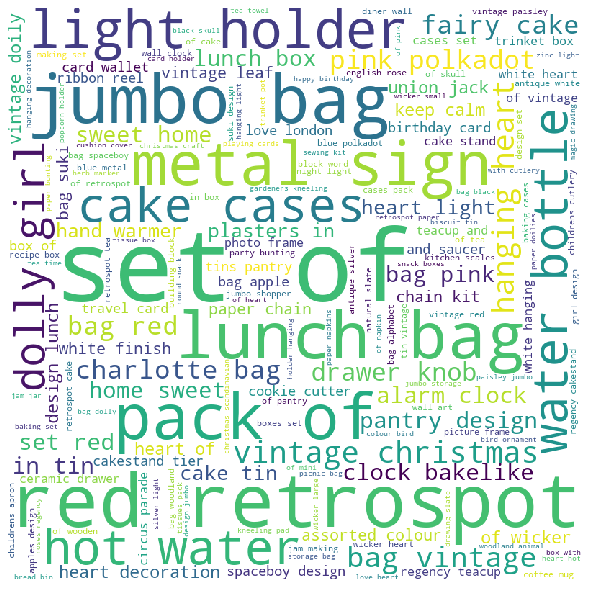

In [24]:
from wordcloud import WordCloud, STOPWORDS

# locally
stopwords = set(STOPWORDS)    

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(' '.join(all_words)) 
                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

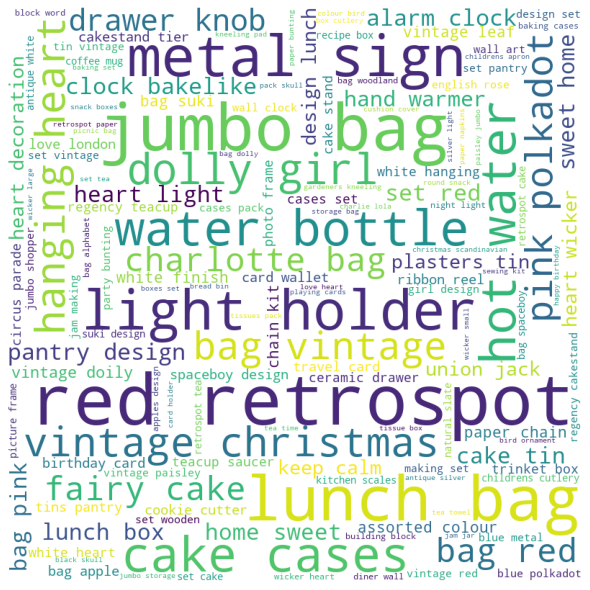

In [22]:
# in colab! 
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(' '.join(all_words)) 
                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#### 2.6.2 discription length & how many words are in top-200

In [25]:
descr_lengths = [len(descr.split()) for descr in df.Description]  # need to know the max length in order to decide how to pad

In [26]:
min(descr_lengths), max(descr_lengths)

(1, 8)

In [27]:
how_many_words_from_top_200 = []
if_more_than_a_half_in_top200 = 0

for descr in df.Description:
    hmwft200 = 0  # hmwft200 = how many words from top2000
    words = [w.lower() for w in descr.split()]
    for w in words:
        if w in top200:
            hmwft200 +=1
    how_many_words_from_top_200.append(hmwft200)
    if hmwft200 >= len(words) // 2:
        if_more_than_a_half_in_top200 += 1

min(how_many_words_from_top_200), max(how_many_words_from_top_200), if_more_than_a_half_in_top200/len(df)

(0, 8, 0.8969855877929502)

Okay, now we can really say that 200-dimensional vectors will be good. So, probably, we can turn Description column into 8 200-dimensional vectors. Then, we can reduce dimension from 1600 to k, turn it into sth dense and append this k new columns to df

### 3. Cancelled orders

In [28]:
df['order_canceled'] = df['InvoiceNo'].apply(lambda x:int('C' in x))
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,...,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,...,0,0,0,0,0,0,0,1,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,...,0,0,0,0,0,0,0,1,0,0


In [29]:
df.order_canceled.value_counts(normalize=True)*100

0    97.790859
1     2.209141
Name: order_canceled, dtype: float64

In [30]:
df.order_canceled.value_counts()

0    392732
1      8872
Name: order_canceled, dtype: int64

### 4 Total sum of order

In [31]:
df['TotalPrice'] = df['UnitPrice'] * df['Quantity'] * (1 - df['order_canceled'])
df.sort_values('TotalPrice')[-3:]  # most expensive

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,...,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified,order_canceled,TotalPrice
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,2011,6,...,0,0,0,0,0,0,1,0,0,38970.0
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,2011,1,...,0,0,0,0,0,0,1,0,0,77183.6
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,2011,12,...,0,0,0,0,0,0,1,0,0,168469.6


### 5 Feature space

In [32]:
for col in df.columns:
    print(f'Column {col} has {len(np.unique(df[col]))} unique values and dtype {df.dtypes[col]}')

Column InvoiceNo has 22190 unique values and dtype object
Column StockCode has 3684 unique values and dtype object
Column Description has 3896 unique values and dtype object
Column Quantity has 436 unique values and dtype int64
Column InvoiceDate has 20460 unique values and dtype datetime64[ns]
Column UnitPrice has 620 unique values and dtype float64
Column CustomerID has 4372 unique values and dtype object
Column Country has 37 unique values and dtype object
Column year has 2 unique values and dtype int64
Column month has 12 unique values and dtype int64
Column dayofweek has 6 unique values and dtype int64
Column weekofyear has 51 unique values and dtype int64
Column hour has 15 unique values and dtype int64
Column dayofyear has 298 unique values and dtype int64
Column is_UK has 2 unique values and dtype int64
Column Australia has 2 unique values and dtype uint8
Column Austria has 2 unique values and dtype uint8
Column Bahrain has 2 unique values and dtype uint8
Column Belgium has 2 u

### 6. Some plotting

Text(0.5, 1.0, 'Total price of the same units put in 1 order per country')

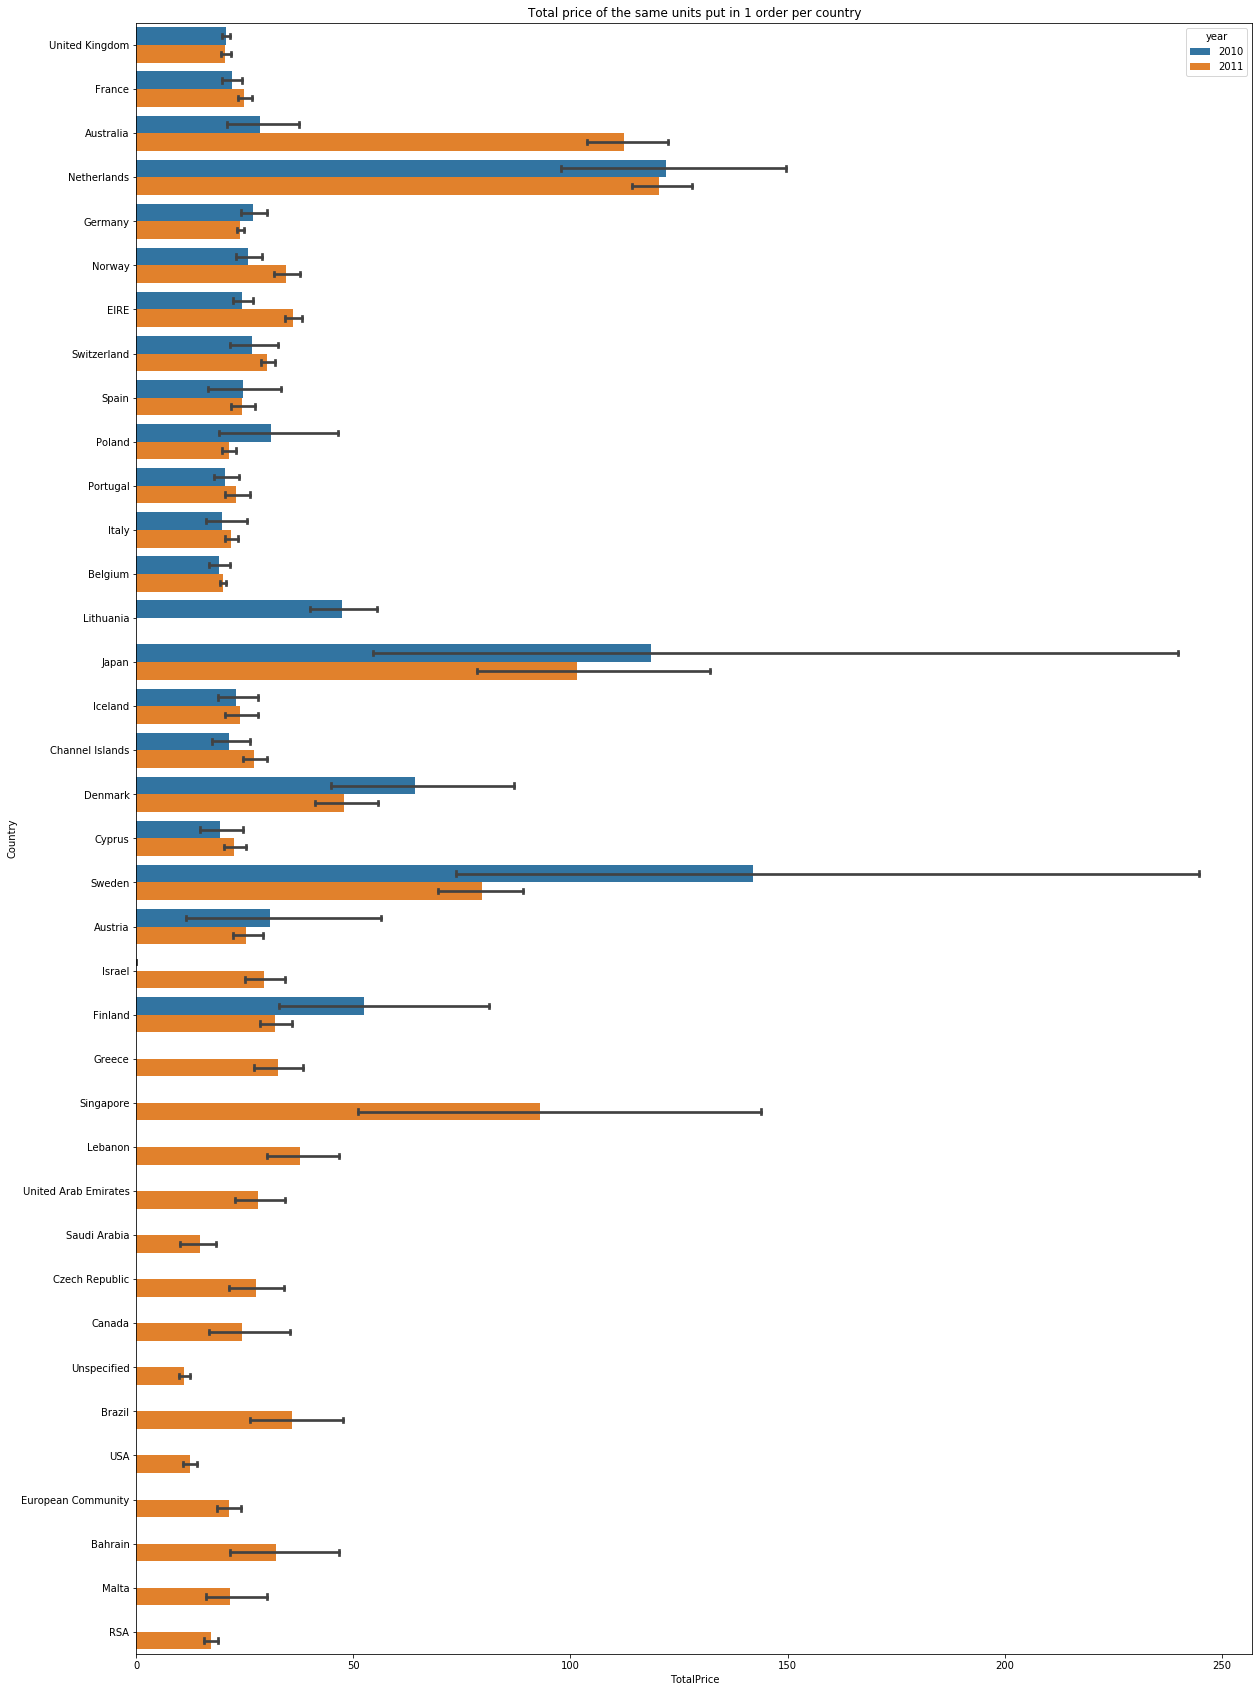

In [33]:
plt.figure(figsize=(20 ,30))
sns.barplot(x="TotalPrice", y="Country", hue="year", data=df, capsize=.1)
plt.title('Total price of the same units put in 1 order per country')

In [34]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo', 'Country', 'year', 'dayofyear'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket_Price'})
basket_price

,CustomerID,InvoiceNo,Country,year,dayofyear,Basket_Price
0,12346,541431,United Kingdom,2011,18,77183.60
1,12346,C541433,United Kingdom,2011,18,0.00
2,12347,537626,Iceland,2010,341,711.79
3,12347,542237,Iceland,2011,26,475.39
4,12347,549222,Iceland,2011,97,636.25
...,...,...,...,...,...,...
22185,18283,579673,United Kingdom,2011,334,220.31
22186,18283,580872,United Kingdom,2011,340,208.00
22187,18287,554065,United Kingdom,2011,142,765.28
22188,18287,570715,United Kingdom,2011,285,1001.32


Text(0.5, 1.0, 'Total price of 1 order per country')

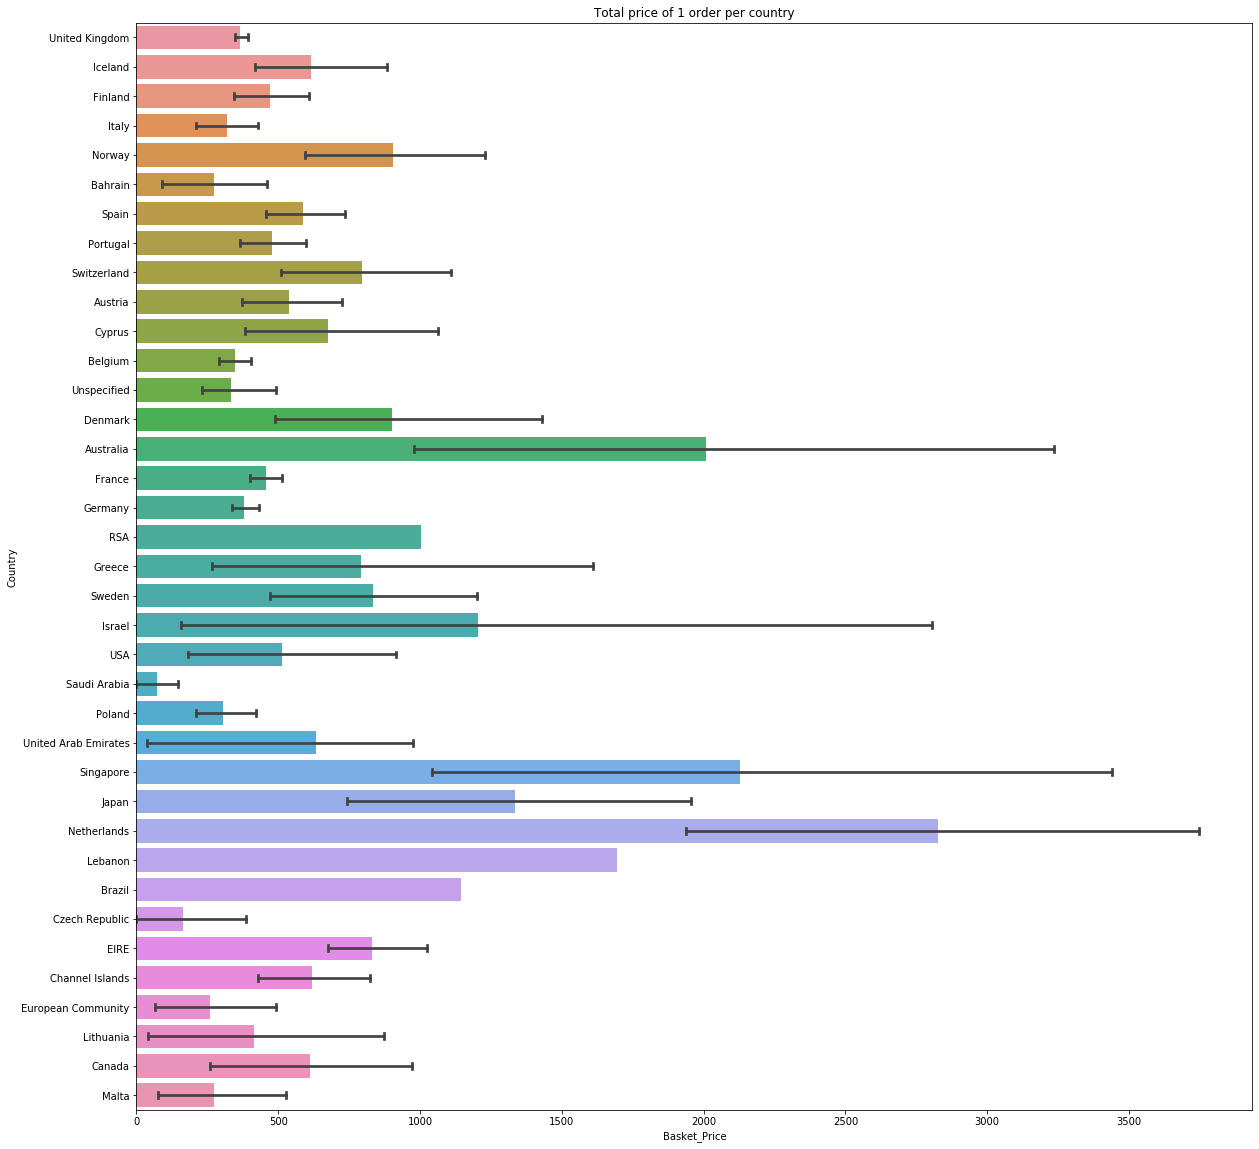

In [36]:
plt.figure(figsize=(20 ,20))
sns.barplot(x="Basket_Price", y="Country", data=basket_price, capsize=.2)
plt.title('Total price of 1 order per country')

In [37]:
basket_price_2010, basket_price_2011 = basket_price[basket_price.year==2010].sort_values('dayofyear').reset_index(), basket_price[basket_price.year==2011].sort_values('dayofyear').reset_index()
df.year.value_counts()

2011    375250
2010     26354
Name: year, dtype: int64

In [71]:
# _, axs = plt.subplots(9, 4, figsize=(18, 46))
# axs = axs.flatten()

# for country, ax in zip(np.unique(basket_price_2011.Country), axs):
#     ax.set_title(f'Basket Price in 2011, {country}')
#     df_2011_country = basket_price_2011[basket_price_2011.Country==country].reset_index()
#     x_time = df_2011_country.dayofyear.values
#     y_money_flow = df_2011_country.Basket_Price.values
#     ax.plot(x_time, y_money_flow)
# plt.show()

Text(0.5, 1.0, 'Order Price across countries in 2010')

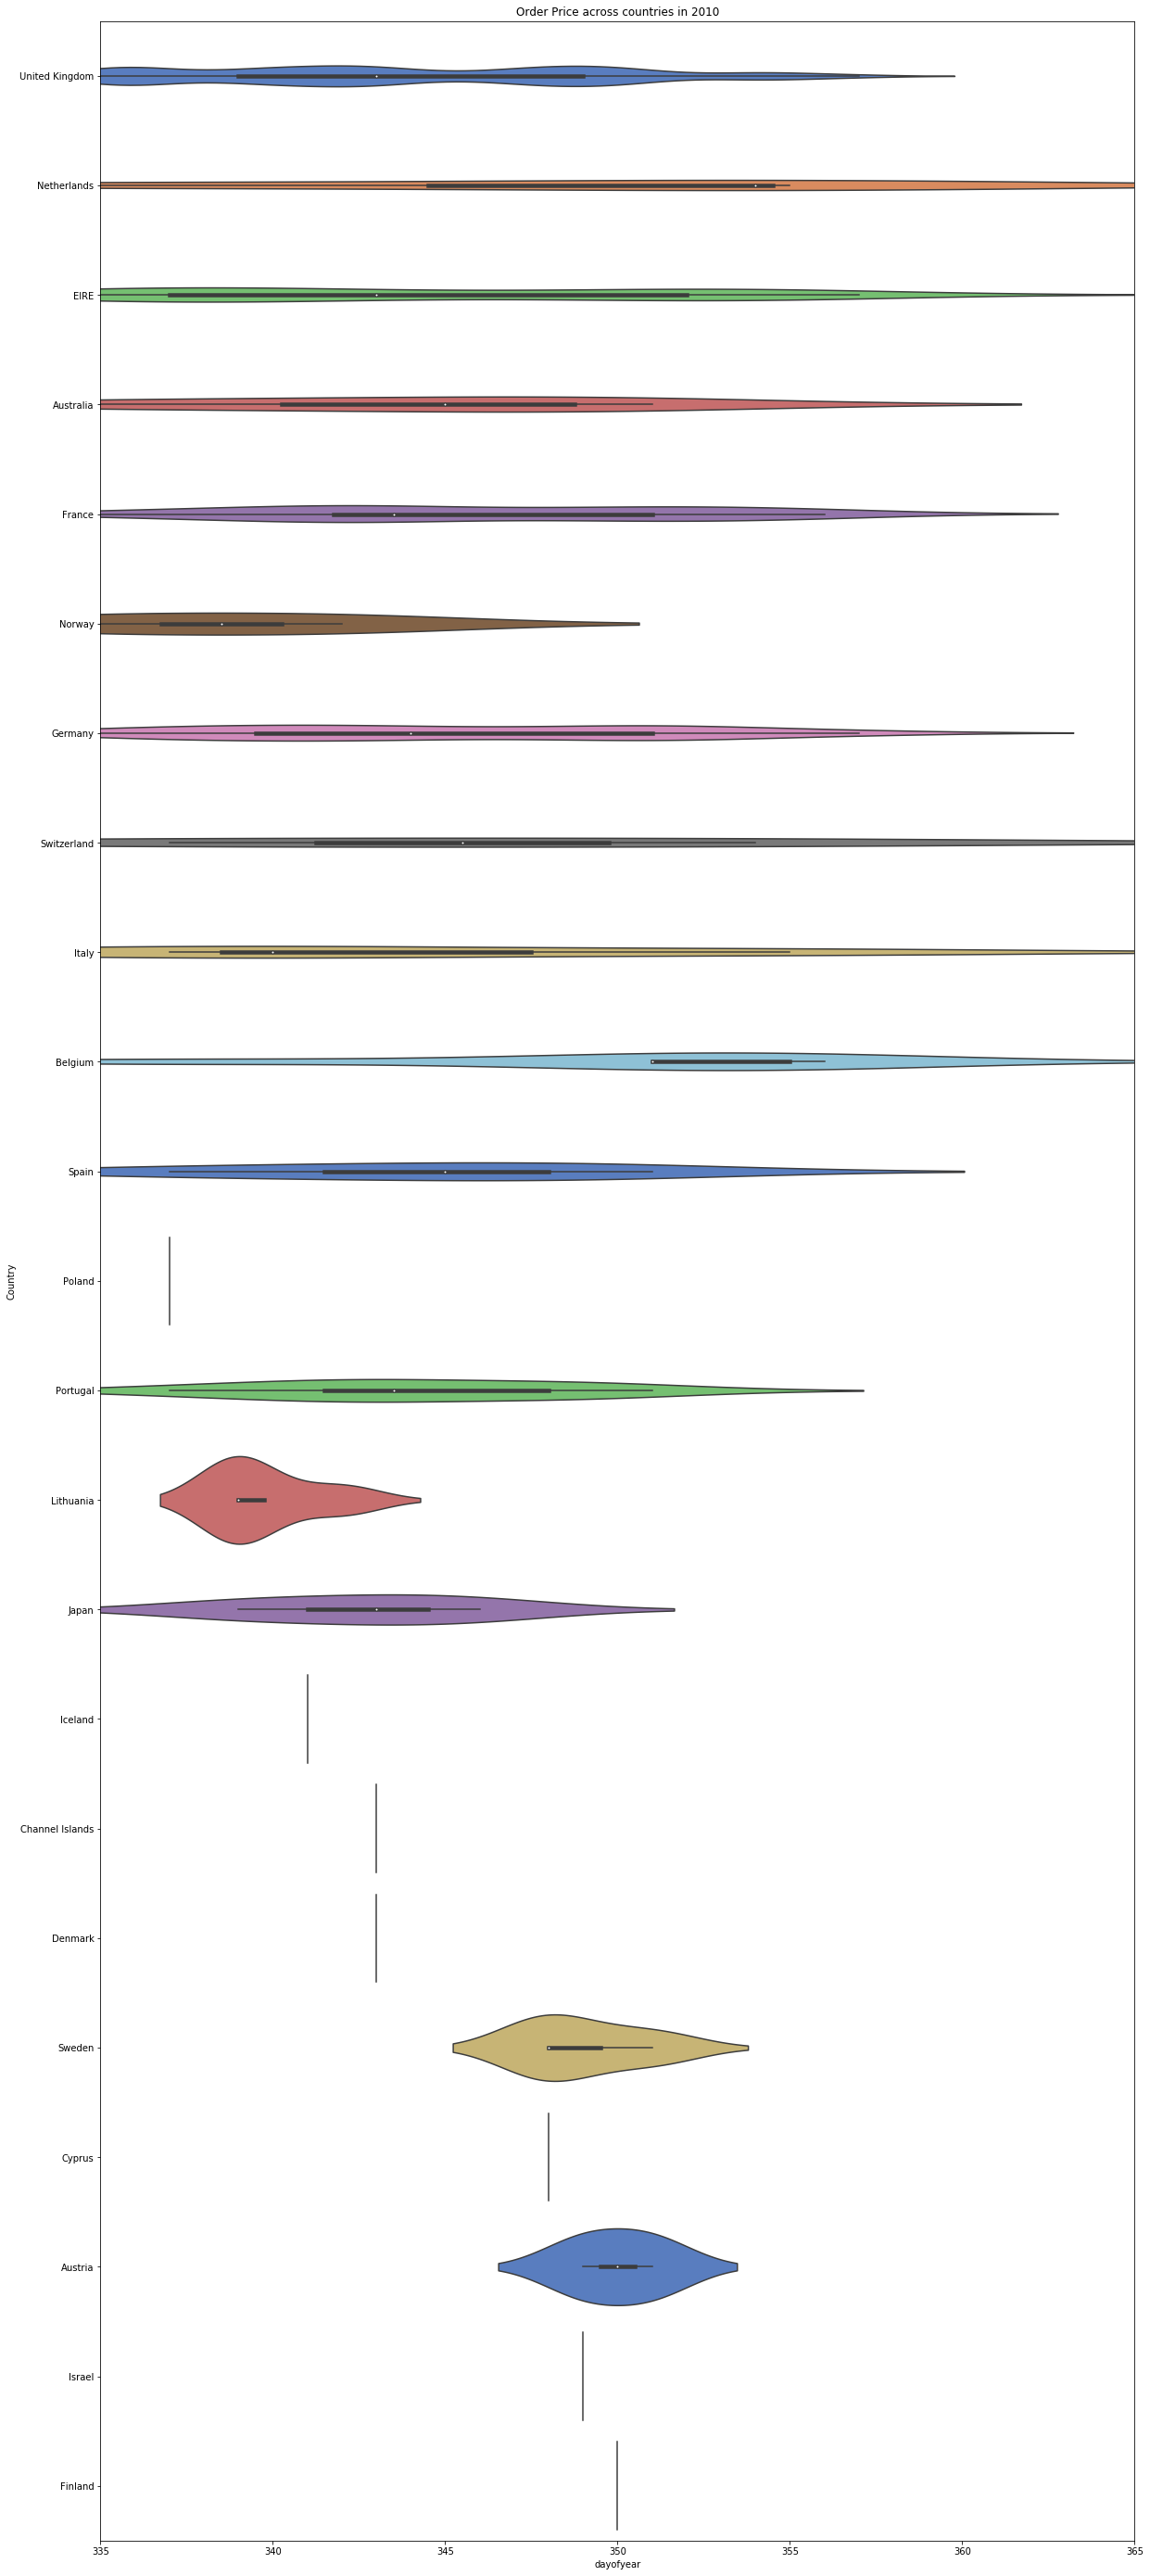

In [38]:
plt.figure(figsize=(20, 50))
plt.xlim(basket_price_2010.dayofyear.min(), 365)
sns.violinplot(x="dayofyear", y="Country",
                    data=basket_price_2010, palette="muted")
plt.title('Order Price across countries in 2010')

Text(0.5, 1.0, 'Order Price across countries in 2010-2011')

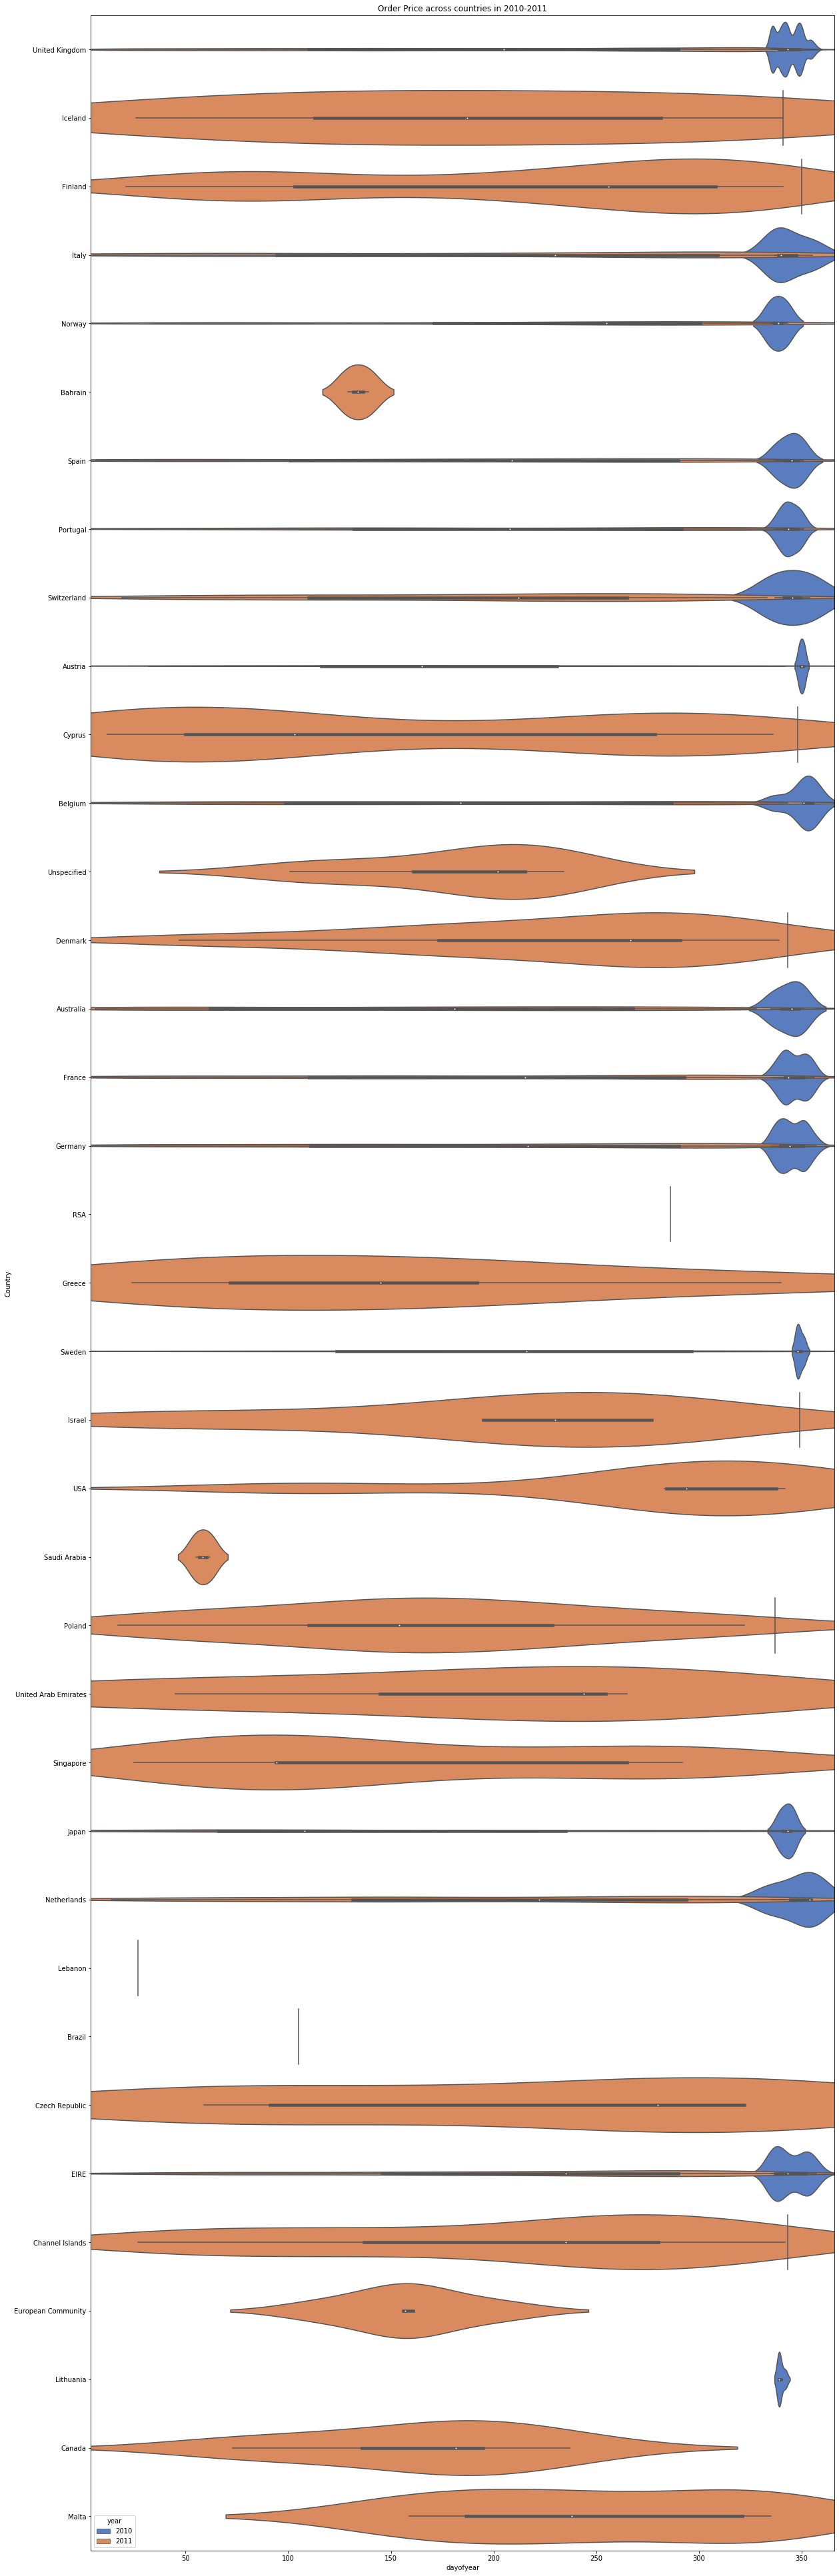

In [39]:
plt.figure(figsize=(20, 70))
plt.xlim(basket_price.dayofyear.min(), 366)
sns.violinplot(x="dayofyear", y="Country", hue='year',
                    data=basket_price, palette="muted", dodge=False)
plt.title('Order Price across countries in 2010-2011')

In [40]:
order_in_time = df[df.year==2011].groupby(by=['dayofyear', 'Country'], as_index=False)['TotalPrice'].sum()
order_in_time = order_in_time.rename(columns = {'TotalPrice':'Basket_Price'})
order_in_time

,dayofyear,Country,Basket_Price
0,4,Sweden,547.56
1,4,United Kingdom,11557.55
2,5,Belgium,0.00
3,5,EIRE,0.00
4,5,France,1391.18
...,...,...,...
1571,343,Belgium,208.64
1572,343,France,249.45
1573,343,Germany,1689.72
1574,343,Norway,2638.69


Text(0.5, 1, 'Order price per day in 2011')

<Figure size 1080x1080 with 0 Axes>

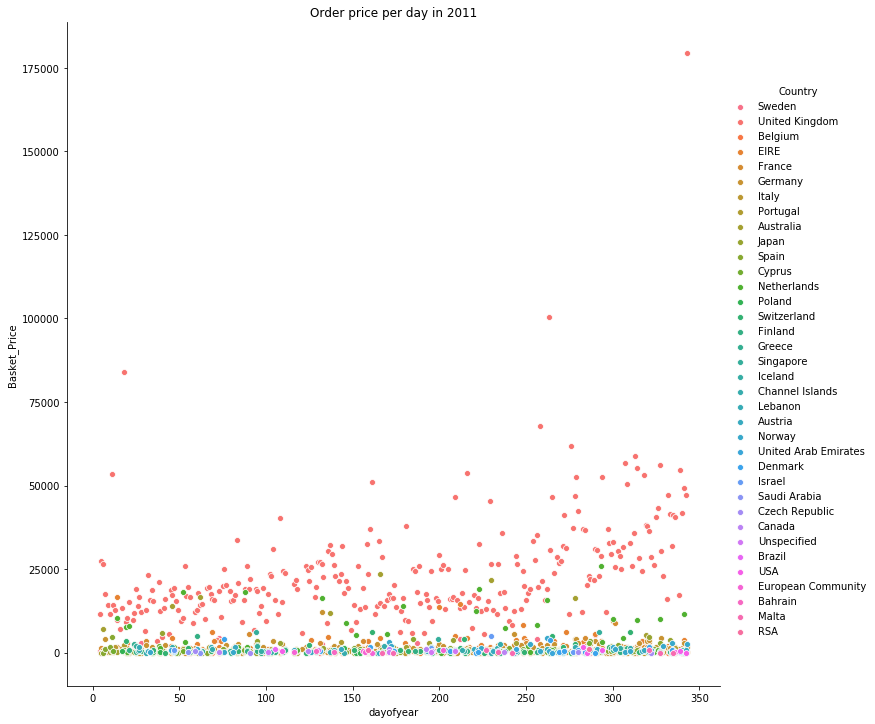

In [41]:
plt.figure(figsize=(15, 15))
sns.pairplot(x_vars=["dayofyear"], y_vars=["Basket_Price"], data=order_in_time, hue="Country", size=10)
plt.title('Order price per day in 2011')

Text(0.5, 1.0, 'Order price per day in 2011')

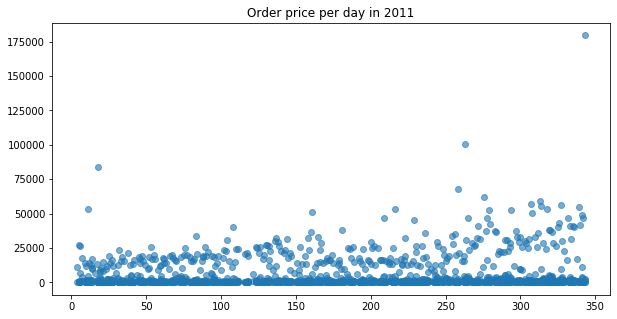

In [42]:
x_day = order_in_time.dayofyear
y_day = order_in_time.Basket_Price
plt.figure(figsize=(10, 5))
plt.scatter(x_day, y_day, alpha=0.6)
plt.title('Order price per day in 2011')

## 7. Preparing the data

Before we do clustering, we have to: 
    
    - feature stuff (drop all non-numerical features)
    - train-test split
    - rescaling
    - reducing dimension 
    
    
Later:

    - clustering
    - classification/regression with cluster_index as a new feature

### 7.1. Preparing numerical data

In [43]:
# df['CustomerHash'] = df.CustomerID.apply(lambda x: hash_encode(x, 15))

In [44]:
# for obj_column in df.columns[df.dtypes==object].tolist():
#     if obj_column!='Country':  # Country is already done
#         hash_column_name = obj_column + 'Hash'
#         df[hash_column_name] = df[obj_column].apply(lambda val: int(hash_encode(val, 12)))  # idk, had to add int()
# df.info()

In [50]:
df_numerical = df.drop(columns=['StockCode', 'Description', 'Country', 'CustomerID'])

In [51]:
df_numerical.columns

Index(['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'year', 'month',
       'dayofweek', 'weekofyear', 'hour', 'dayofyear', 'is_UK', 'Australia',
       'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada', 'Channel Islands',
       'Cyprus', 'Czech Republic', 'Denmark', 'EIRE', 'European Community',
       'Finland', 'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy',
       'Japan', 'Lebanon', 'Lithuania', 'Malta', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'RSA', 'Saudi Arabia', 'Singapore', 'Spain',
       'Sweden', 'Switzerland', 'USA', 'United Arab Emirates',
       'United Kingdom', 'Unspecified', 'order_canceled', 'TotalPrice'],
      dtype='object')

In [52]:
# InvoiceNo will be dropped later

### 7.2. Grouping, adding basket price

In [53]:
df_numerical_grouped = df_numerical.groupby(by=['InvoiceNo'], as_index=False)['TotalPrice'].sum()
df_numerical_grouped = df_numerical_grouped.rename(columns = {'TotalPrice':'Basket_Price'})
df_numerical_grouped

,InvoiceNo,Basket_Price
0,536365,139.12
1,536366,22.20
2,536367,278.73
3,536368,70.05
4,536369,17.85
...,...,...
22185,C581484,0.00
22186,C581490,0.00
22187,C581499,0.00
22188,C581568,0.00


In [56]:
df_numerical_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22190 entries, 0 to 22189
Data columns (total 2 columns):
InvoiceNo       22190 non-null object
Basket_Price    22190 non-null float64
dtypes: float64(1), object(1)
memory usage: 520.1+ KB


In [57]:
def get_basket_from_invoice(invoice_num_hash):
    invoice_num_hash = str(invoice_num_hash)
    return df_numerical_grouped[df_numerical_grouped.InvoiceNo == invoice_num_hash].Basket_Price.values[0]

get_basket_from_invoice('536365')

139.12

In [58]:
df_numerical['Basket_Price'] = df_numerical.apply(lambda row: get_basket_from_invoice(row['InvoiceNo']), axis=1)
df_numerical.head(2)

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,year,month,dayofweek,weekofyear,hour,dayofyear,...,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified,order_canceled,TotalPrice,Basket_Price
0,536365,6,2010-12-01 08:26:00,2.55,2010,12,2,48,8,335,...,0,0,0,0,0,1,0,0,15.30,139.12
1,536365,6,2010-12-01 08:26:00,3.39,2010,12,2,48,8,335,...,0,0,0,0,0,1,0,0,20.34,139.12


In [60]:
df_numerical = df_numerical.drop(columns=['InvoiceNo'])
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 50 columns):
Quantity                401604 non-null int64
InvoiceDate             401604 non-null datetime64[ns]
UnitPrice               401604 non-null float64
year                    401604 non-null int64
month                   401604 non-null int64
dayofweek               401604 non-null int64
weekofyear              401604 non-null int64
hour                    401604 non-null int64
dayofyear               401604 non-null int64
is_UK                   401604 non-null int64
Australia               401604 non-null uint8
Austria                 401604 non-null uint8
Bahrain                 401604 non-null uint8
Belgium                 401604 non-null uint8
Brazil                  401604 non-null uint8
Canada                  401604 non-null uint8
Channel Islands         401604 non-null uint8
Cyprus                  401604 non-null uint8
Czech Republic          401604 non-null uint8
Denm

In [63]:
# leaving InvoiceDate for later stuff

### 7.3 Train-test split * 2

We will consider 2 splits: random and time-wise :) depending on the task we will decide which split we use.
Rescaling, dimensionality reduction and clustering will be performed on both splits independently

In [64]:
# random split

from sklearn.model_selection import train_test_split

df_random_train, df_random_test = train_test_split(df_numerical, test_size=0.2, random_state=0)
df_random_train.shape, df_random_test.shape 

((321283, 50), (80321, 50))

In [66]:
df_numerical_time_sorted = df_numerical.sort_values('InvoiceDate')
df_numerical_time_sorted  # good

,Quantity,InvoiceDate,UnitPrice,year,month,dayofweek,weekofyear,hour,dayofyear,is_UK,...,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified,order_canceled,TotalPrice,Basket_Price
0,6,2010-12-01 08:26:00,2.55,2010,12,2,48,8,335,1,...,0,0,0,0,0,1,0,0,15.30,139.12
1,6,2010-12-01 08:26:00,3.39,2010,12,2,48,8,335,1,...,0,0,0,0,0,1,0,0,20.34,139.12
2,8,2010-12-01 08:26:00,2.75,2010,12,2,48,8,335,1,...,0,0,0,0,0,1,0,0,22.00,139.12
3,6,2010-12-01 08:26:00,3.39,2010,12,2,48,8,335,1,...,0,0,0,0,0,1,0,0,20.34,139.12
4,6,2010-12-01 08:26:00,3.39,2010,12,2,48,8,335,1,...,0,0,0,0,0,1,0,0,20.34,139.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541896,12,2011-12-09 12:50:00,1.65,2011,12,4,49,12,343,0,...,0,0,0,0,0,0,0,0,19.80,249.45
541895,12,2011-12-09 12:50:00,1.65,2011,12,4,49,12,343,0,...,0,0,0,0,0,0,0,0,19.80,249.45
541907,4,2011-12-09 12:50:00,4.15,2011,12,4,49,12,343,0,...,0,0,0,0,0,0,0,0,16.60,249.45
541900,4,2011-12-09 12:50:00,3.75,2011,12,4,49,12,343,0,...,0,0,0,0,0,0,0,0,15.00,249.45


In [79]:
# TS split 1

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3) 
for train_index, test_index in tscv.split(df_numerical_time_sorted):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_ts_train, df_ts_test = df_numerical_time_sorted.iloc[train_index, :], df_numerical_time_sorted.iloc[test_index, :]
    
df_ts_train.shape, df_ts_test.shape

TRAIN: [     0      1      2 ... 100398 100399 100400] TEST: [100401 100402 100403 ... 200799 200800 200801]
TRAIN: [     0      1      2 ... 200799 200800 200801] TEST: [200802 200803 200804 ... 301200 301201 301202]
TRAIN: [     0      1      2 ... 301200 301201 301202] TEST: [301203 301204 301205 ... 401601 401602 401603]


((301203, 50), (100401, 50))

In [80]:
df_ts_test.head(1)

,Quantity,InvoiceDate,UnitPrice,year,month,dayofweek,weekofyear,hour,dayofyear,is_UK,...,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified,order_canceled,TotalPrice,Basket_Price
408890,10,2011-10-20 12:00:00,0.85,2011,10,3,42,12,293,1,...,0,0,0,0,0,1,0,0,8.5,23.5


In [82]:
# second TS split :) - will prefer this
df_ts_train_k = df_numerical_time_sorted[df_numerical_time_sorted.InvoiceDate <= datetime.date(2011, 10, 1)]
df_ts_test_k = df_numerical_time_sorted[df_numerical_time_sorted.InvoiceDate > datetime.date(2011, 10, 1)]
df_ts_train_k.shape, df_ts_test_k.shape

((270062, 50), (131542, 50))

### 7.4 Rescaling using MMS

In [85]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
#  the last one is robust to outliers, for experiment used on ts-split-1 only

mm_random, mm_ts = MinMaxScaler(), MinMaxScaler()

df_random_train_mm = mm_random.fit_transform(df_random_train.drop('InvoiceDate', axis=1))
df_random_test_mm = mm_random.transform(df_random_test.drop('InvoiceDate', axis=1))

df_ts_train_k_mm = mm_ts.fit_transform(df_ts_train_k.drop('InvoiceDate', axis=1))
df_ts_test_k_mm = mm_ts.transform(df_ts_test_k.drop('InvoiceDate', axis=1))

rs = RobustScaler()
df_ts_train_rs = rs.fit_transform(df_ts_train.drop('InvoiceDate', axis=1))
df_ts_test_rs = rs.transform(df_ts_test.drop('InvoiceDate', axis=1))

### 7.5 Reducing dimension and plotting :)

In [100]:
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import time

# Let's just visualize on plane some relatively small chunk of our train set

def plot_tsne_xtrain(X_train, chunk_size=500):
    """
    Reduces dimensionality of some part of rescaled X_train in Pipeline with 
    PCA and t-SNE and plots it on plane.
    Args:
        X_train: train set 
        chunk_size: number of first rows to plot
    """
        
    X_train_small = X_train[:chunk_size, :]

    pca_tsne = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=0)),
        ("tsne", TSNE(n_components=2, random_state=0)),
    ])
    t0 = time.time()
    X_pca_tsne_reduced_train = pca_tsne.fit_transform(X_train_small)
    t1 = time.time()
    print(f"Pipeline with PCA and t-SNE took on dataset of shape {X_train_small.shape} {round(t1-t0, 2)}s")


    fig = plt.figure(figsize=(8,8))
    plt.scatter(X_pca_tsne_reduced_train[:, 0], X_pca_tsne_reduced_train[:, 1])
    plt.xlabel('component 1')
    plt.ylabel('component 2')

    
plot_tsne_xtrain(df_random_train_mm, chunk_size=10000)

In [101]:
# plot_tsne_xtrain(df_ts_train_k_mm, chunk_size=10000)

In [102]:
# plot_tsne_xtrain(df_ts_train_rs, chunk_size=10000)

## 8. Clustering!

In [113]:
kmeans = KMeans(init='k-means++', n_clusters = 5, n_init=30)
kmeans.fit(df_random_train_mm)
clusters = kmeans.predict(df_random_train_mm)
silhouette_avg = silhouette_score(df_random_train_mm, clusters)
print("For n_clusters =", 5, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.35041687250747267


In [114]:
clusters

array([1, 1, 1, ..., 1, 1, 0])

Pipeline with PCA and t-SNE took 407.28s on data of shape (100000, 49)


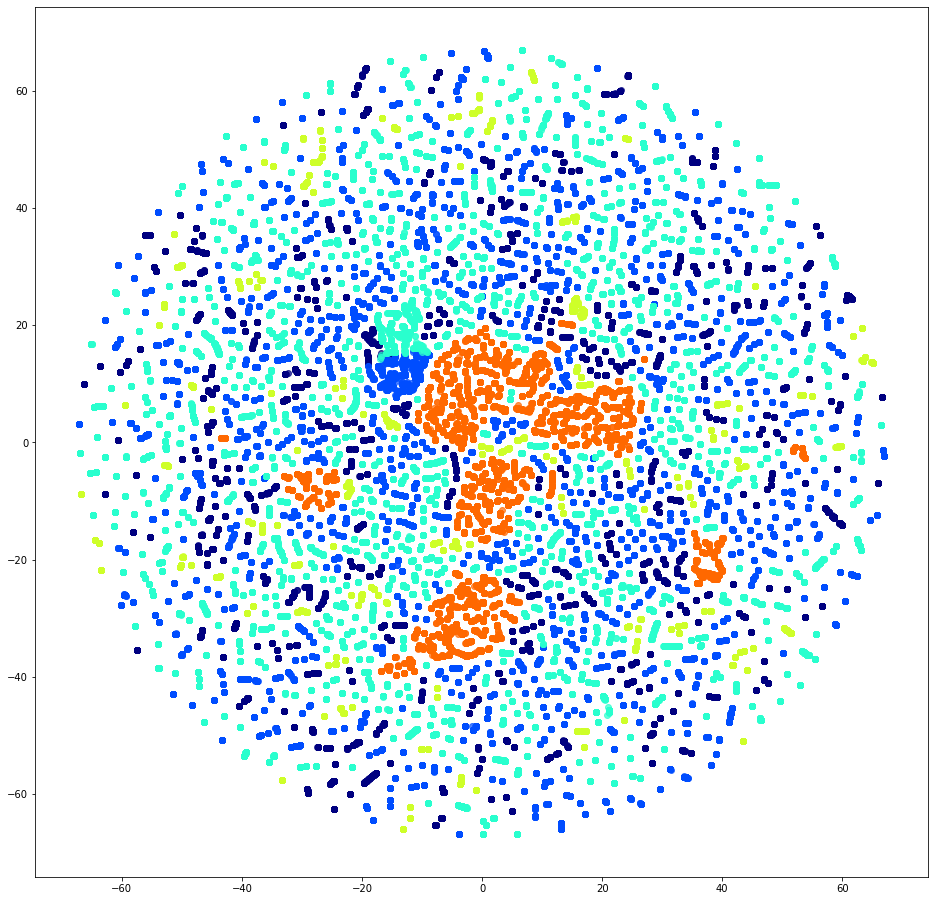

In [115]:
def plot_tsne_xtrain_clusters(X_train, clusters, chunk_size=500):
    """
    Reduces dimensionality of some part of rescaled X_train in Pipeline with 
    PCA and t-SNE and plots it on plane.
    Args:
        X_train: train set with only pixel values, no need for labels
        chunk_size: number of first rows to plot
    """

    mm = MinMaxScaler()
    X_train_small = mm.fit_transform(X_train[:chunk_size, :])
    y_train_small = clusters[:chunk_size]

    pca_tsne = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=0)),
        ("tsne", TSNE(n_components=2, random_state=0)),
    ])
    t0 = time.time()
    X_pca_tsne_reduced_train = pca_tsne.fit_transform(X_train_small)
    t1 = time.time()
    print(f"Pipeline with PCA and t-SNE took {round(t1-t0, 2)}s on data of shape {X_train_small.shape}")

    fig = plt.figure(figsize=(16,16))
    cmap = mpl.cm.get_cmap("jet")
    c_labels = np.unique(y_train_small)
    for em in c_labels:
        plt.scatter(X_pca_tsne_reduced_train[y_train_small == em, 0], 
                    X_pca_tsne_reduced_train[y_train_small == em, 1], 
                    c=[cmap(em / len(c_labels))], 
                    alpha=0.7)


plot_tsne_xtrain_clusters(df_random_train_mm, clusters, 100000)

For n_clusters = 3 the average silhouette_score is : 0.37094974339193754
Clustering took 24.259559154510498s and calculating silhoutte score took 1189.9208557605743s
Pipeline with PCA and t-SNE took 57.37s on data of shape (10000, 49)
For n_clusters = 4 the average silhouette_score is : 0.4002400377252727
Clustering took 32.60182189941406s and calculating silhoutte score took 1210.5225148200989s
Pipeline with PCA and t-SNE took 56.96s on data of shape (10000, 49)
For n_clusters = 5 the average silhouette_score is : 0.35041687250747267
Clustering took 37.146984577178955s and calculating silhoutte score took 1174.1125741004944s
Pipeline with PCA and t-SNE took 59.07s on data of shape (10000, 49)
For n_clusters = 6 the average silhouette_score is : 0.3513359220089126
Clustering took 39.796058177948s and calculating silhoutte score took 1149.6778764724731s
Pipeline with PCA and t-SNE took 57.31s on data of shape (10000, 49)
For n_clusters = 7 the average silhouette_score is : 0.30668774070

<Figure size 504x504 with 0 Axes>

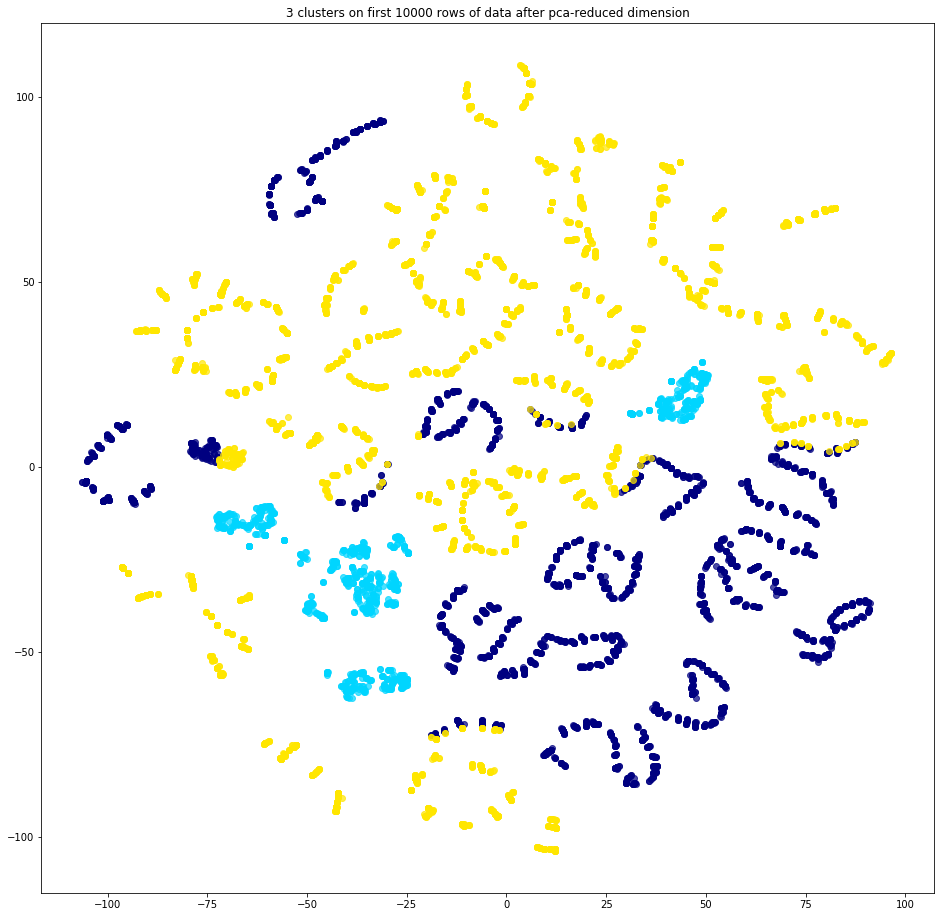

<Figure size 504x504 with 0 Axes>

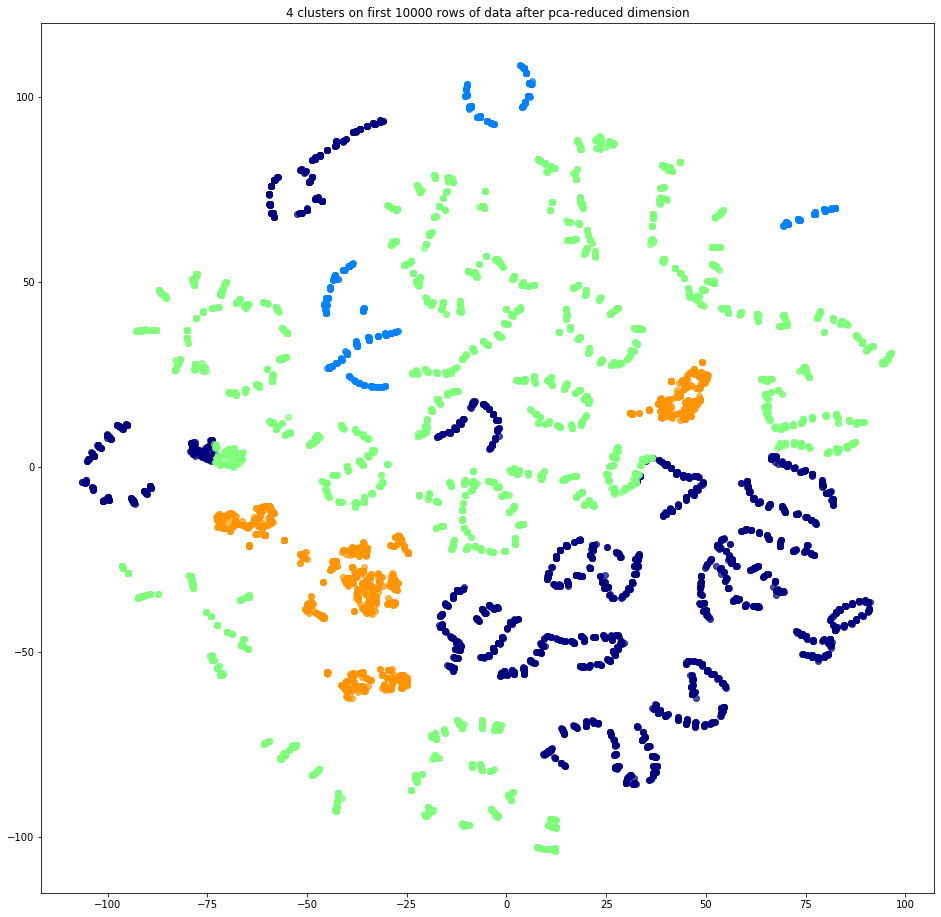

<Figure size 504x504 with 0 Axes>

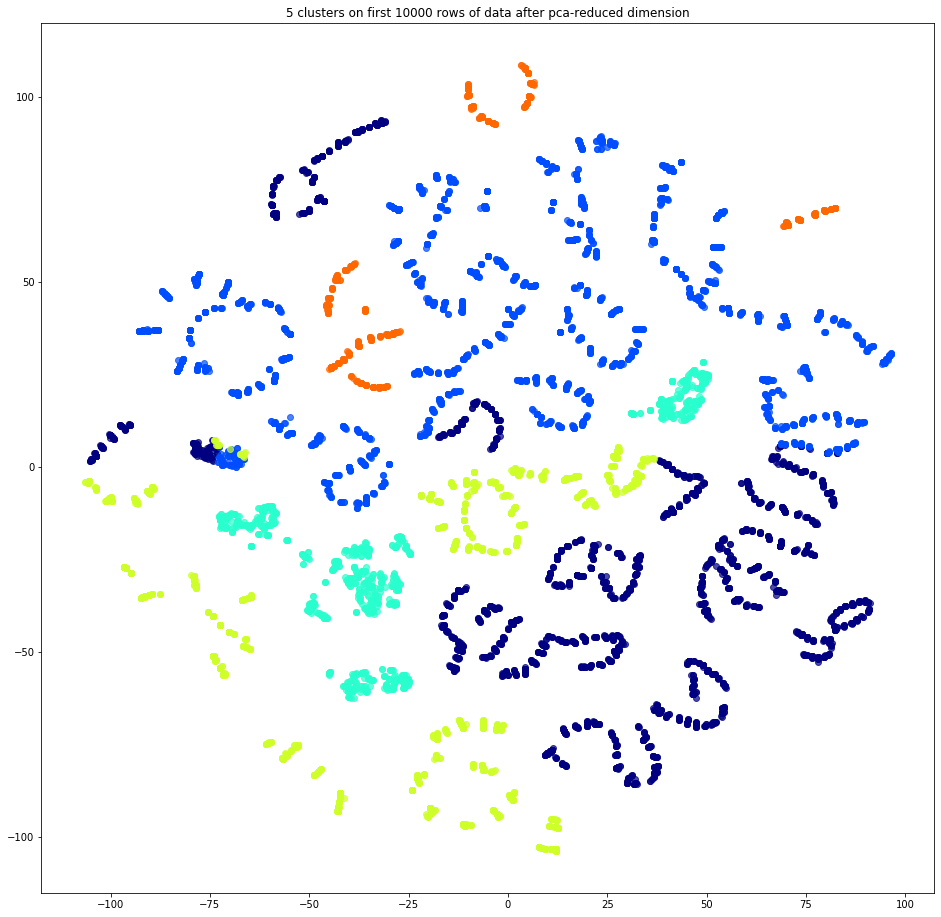

<Figure size 504x504 with 0 Axes>

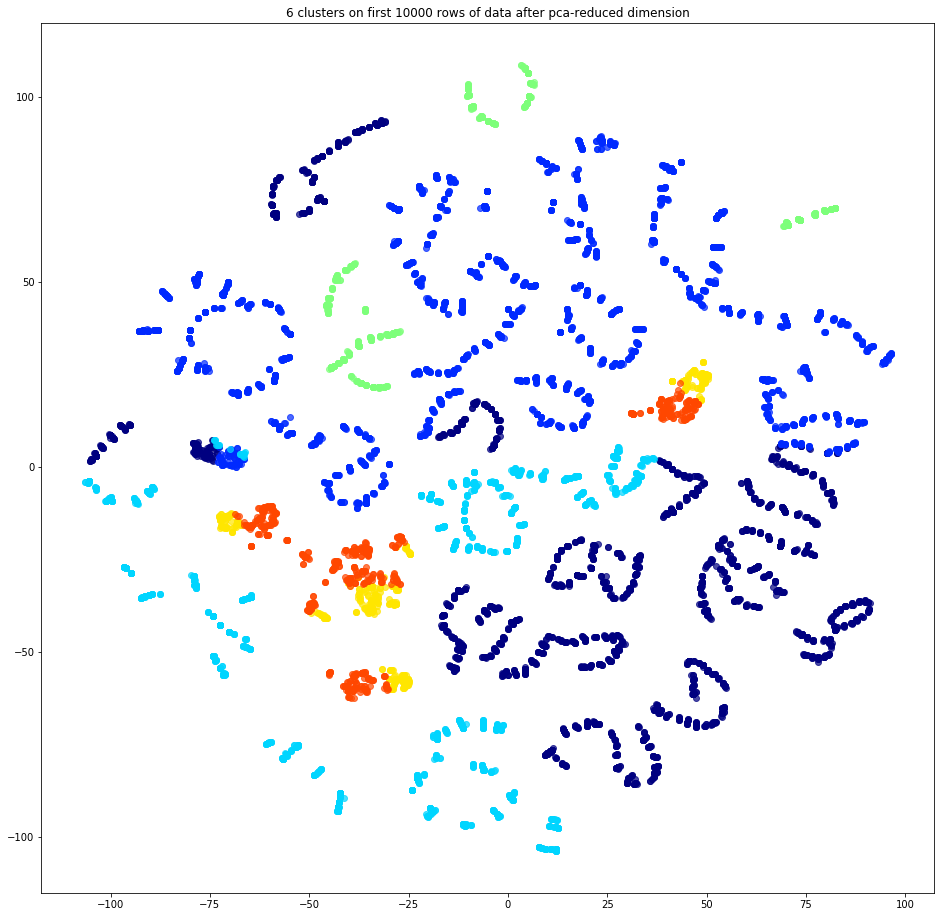

<Figure size 504x504 with 0 Axes>

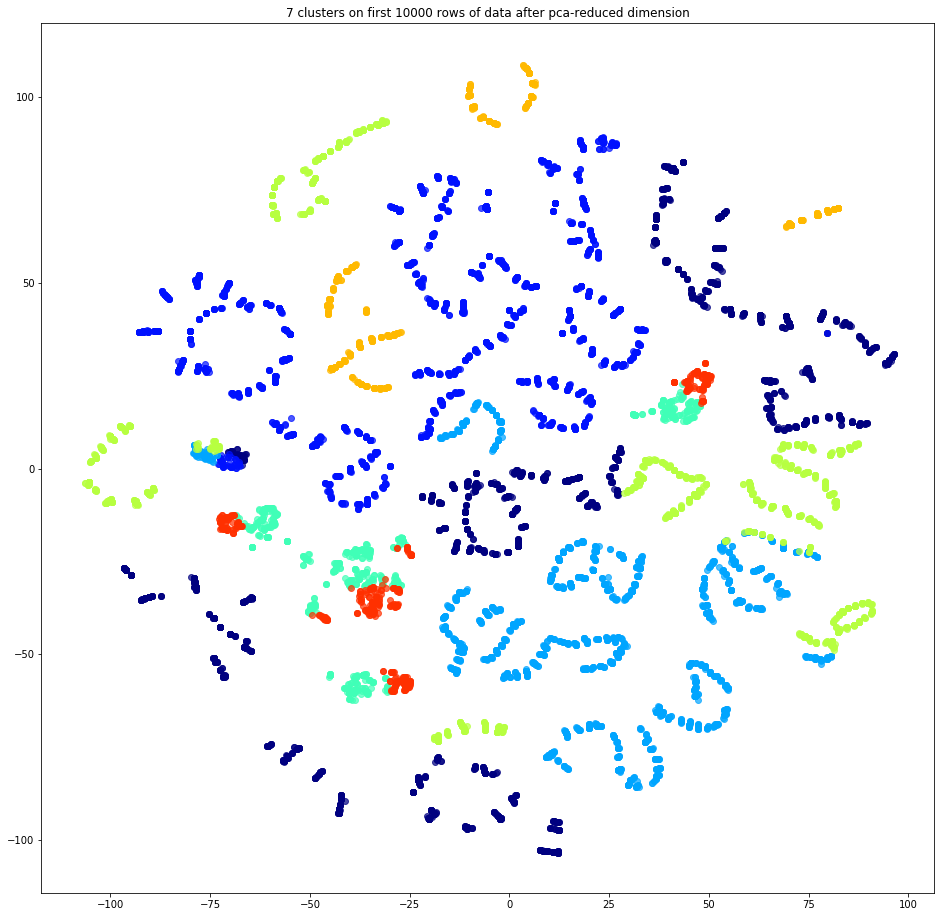

<Figure size 504x504 with 0 Axes>

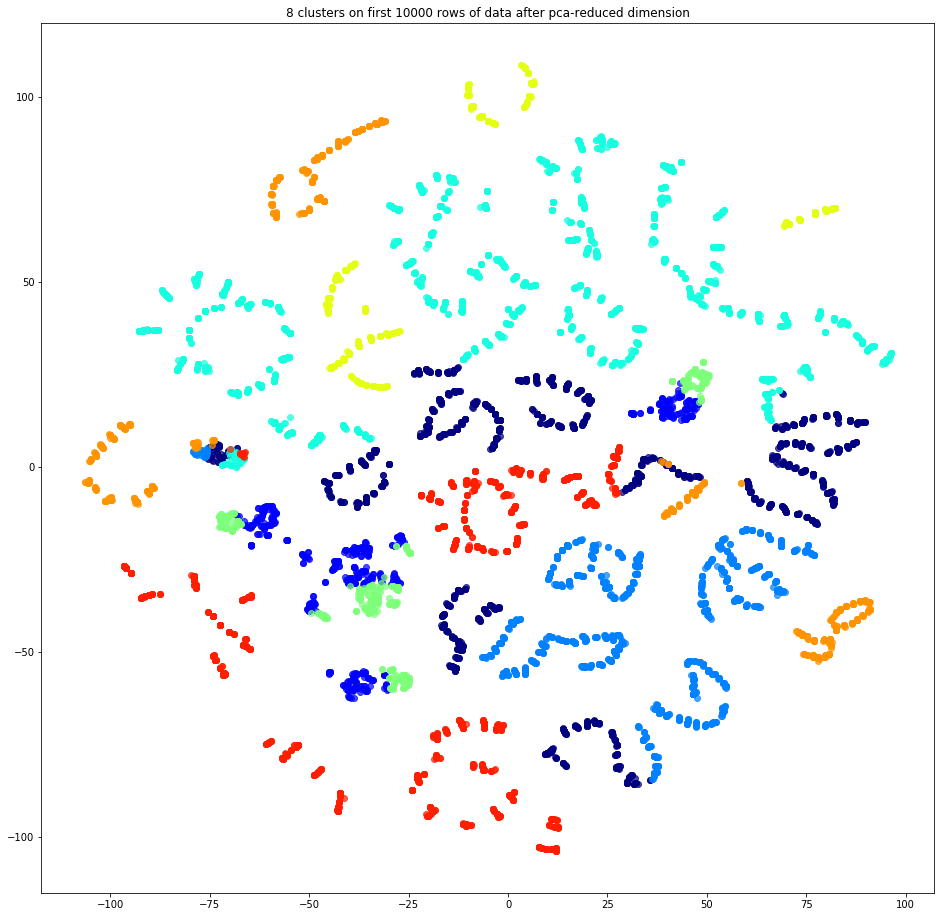

<Figure size 504x504 with 0 Axes>

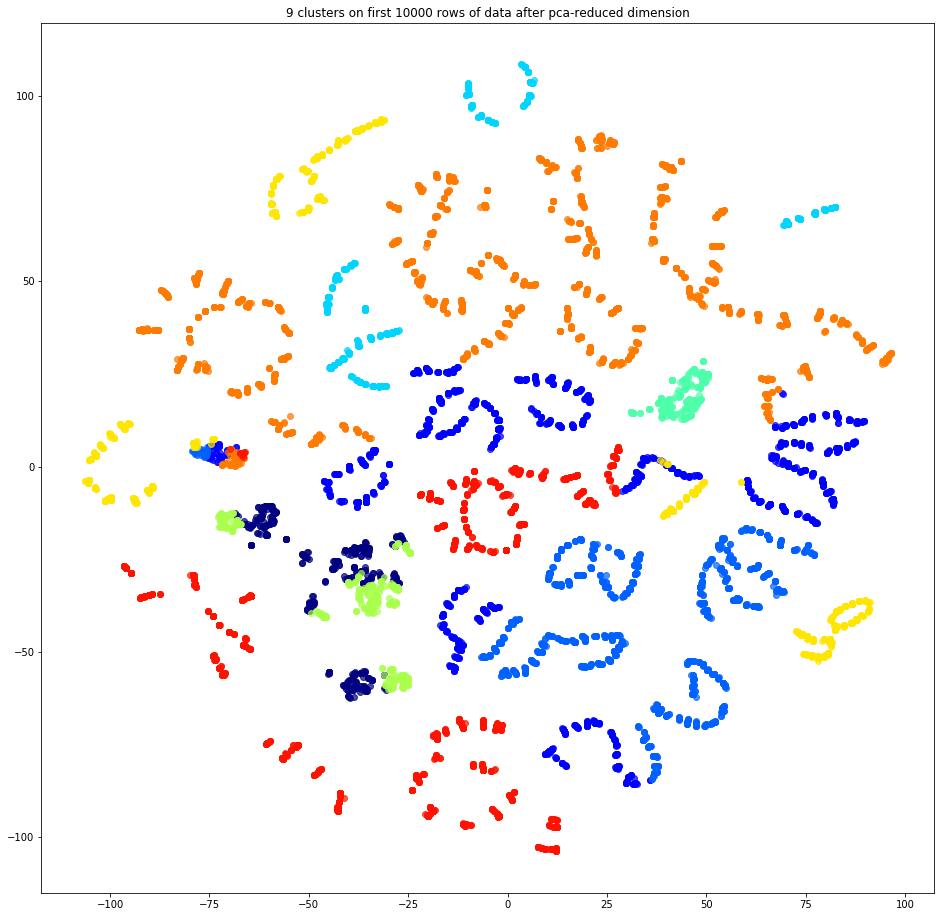

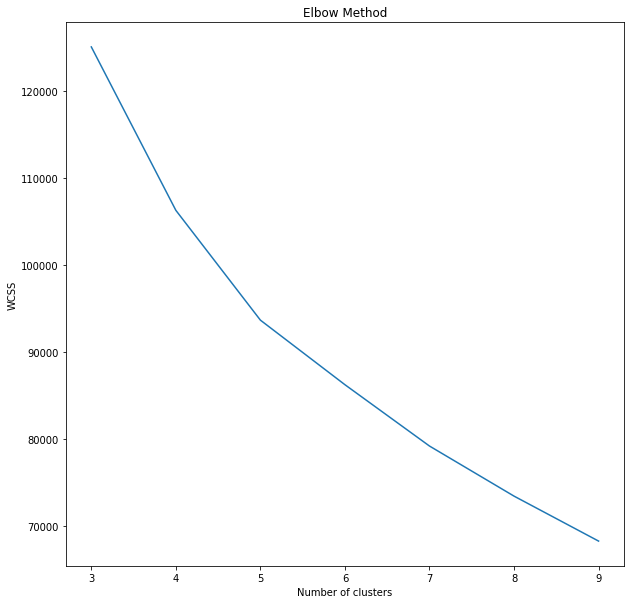

In [122]:
wcss=[]
min_n_clusters = 3
max_n_clusters = 10
for n_c in range(min_n_clusters, max_n_clusters):
    kmeans = KMeans(init='k-means++', n_clusters = n_c, n_init=30)
    t0 = time.time()
    kmeans.fit(df_random_train_mm)
    clusters = kmeans.predict(df_random_train_mm)
    t1 = time.time()
    silhouette_avg = silhouette_score(df_random_train_mm, clusters)
    t2 = time.time()
    wcss.append(kmeans.inertia_)
    print("For n_clusters =", n_c, "the average silhouette_score is :", silhouette_avg)
    print(f'Clustering took {t1-t0}s and calculating silhoutte score took {t2-t1}s')
    plt.figure(figsize=(7, 7))     
    chunk_size=10000
    plot_tsne_xtrain_clusters(df_random_train_mm, clusters, chunk_size = chunk_size)
    plt.title(f'{n_c} clusters on first {chunk_size} rows of data after pca-reduced dimension')
    
    
plt.figure(figsize=(10, 10))        
plt.plot(range(min_n_clusters, max_n_clusters), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()